# SAN-VQA Demonstration on DVQA Dataset

---

* Steps
  * Convert the image to features **v**
  *  Convert the question to a torch vector of longs
  *  Pass both into the the VQA model
  *  Interpret the softmax-y answer vectors

* Resources ~ 
  * https://github.com/Cyanogenoid/pytorch-vqa
  * https://github.com/Cyanogenoid/vqa-counting/tree/master/vqa-v2

---

### Table of contents ~
#### 1. Creating the environment
#### 2. Exploring the data
#### 3. Preprocessing the data
#### 4. Training the model
#### 5. Testing the model


## Creating the environment
---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Importing and preparing data

In [ ]:
# Upgrade pillow to latest version to resolve an attribute issue when importing model
! pip install Pillow==9.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import json
import os, sys
import warnings
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
try:
  path = "/content/data"
  os.mkdir(path)
  path = "/content/data/dvqa"
  os.mkdir(path)
  path = "/content/data/images"
  os.mkdir(path)
except:
  print("Folder already exists...")
finally:
  print("The folders are now ready!")

The folders are now ready!


In [ ]:
# Importing images
!unzip '/content/drive/MyDrive/DVQA/images/train.zip' -d '/content/data/images'
!unzip '/content/drive/MyDrive/DVQA/images/test.zip' -d '/content/data/images'
!unzip '/content/drive/MyDrive/DVQA/images/val.zip' -d '/content/data/images'

#### Importing the prebuilt VQA model

In [ ]:
if not os.path.isfile('./pytorch-vqa/README.md'):
    !git clone https://github.com/Cyanogenoid/pytorch-vqa.git
sys.path.append(os.path.realpath('./pytorch-vqa'))

Cloning into 'pytorch-vqa'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 51 (delta 2), reused 6 (delta 2), pack-reused 40
Unpacking objects: 100% (51/51), done.


#### Acelerating using CUDA

In [ ]:
try: 
    import torch
except:
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    accelerator = 'cu80' if os.path.exists('/opt/bin/nvidia-smi') else 'cpu'
    !pip install -q \
      http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl \
      torchvision

In [ ]:
import torch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

## Exploring the data
---

#### For the train set

In [ ]:
json_file_path = "/content/drive/MyDrive/DVQA/qa/train_qa.json"

with open(json_file_path, 'r') as j:
     contents = json.loads(j.read())

dtrain = pd.DataFrame(contents)
dtrain.head()

,question,question_id,template_id,answer,image,answer_bbox
0,Which bar has the largest value?,1101,reasoning,soil,bar_train_00000001.png,"[348.32196969696963, 404.2, 47.875, 37.0]"
1,Which bar has the smallest value?,1102,reasoning,essay,bar_train_00000001.png,"[85.34469696969697, 404.2, 68.625, 37.0]"
2,What is the value of the largest bar?,1103,reasoning,2,bar_train_00000001.png,[]
3,What is the value of the smallest bar?,1104,reasoning,1,bar_train_00000001.png,[]
4,What is the difference between the largest and...,1105,reasoning,1,bar_train_00000001.png,[]


In [ ]:
dtrain[dtrain['image'] == 'bar_train_00020001.png']

,question,question_id,template_id,answer,image,answer_bbox
232489,How many algorithms have accuracy higher than ...,12000101,reasoning,four,bar_train_00020001.png,[]
232490,Which algorithm has the smallest accuracy summ...,12000102,reasoning,trust,bar_train_00020001.png,"[150.66757246376812, 352.82500000000005, 39.0,..."
232491,Which algorithm has the largest accuracy summe...,12000103,reasoning,report,bar_train_00020001.png,"[374.6096014492754, 352.82500000000005, 39.0, ..."
232492,Is the accuracy of the algorithm woman in the ...,12000104,reasoning,yes,bar_train_00020001.png,[]
232493,Are the values in the chart presented in a per...,12000106,data,yes,bar_train_00020001.png,[]
232494,What dataset does the steelblue color represent?,12000107,data,jury,bar_train_00020001.png,"[244.29861111111114, 120.28888888888878, 50.0,..."
232495,What is the accuracy of the algorithm report i...,12000108,data,80,bar_train_00020001.png,[]
232496,What is the label of the third group of bars f...,12000109,data,woman,bar_train_00020001.png,"[206.65307971014494, 352.82500000000005, 39.0,..."
232497,What is the label of the first bar from the le...,12000110,data,hurry,bar_train_00020001.png,"[244.29861111111114, 97.511111111111, 62.0, 35.0]"
232498,How many groups of bars are there?,12000115,structure,six,bar_train_00020001.png,[]


In [ ]:
dtrain = dtrain.iloc[0:232489, :]

In [ ]:
def ImageId(row):
    s = row["image"]
    s = s[10:-4]
    return int(s)
dft = dtrain.assign(image_id=dtrain.apply(ImageId, axis=1))
dft.head()

,question,question_id,template_id,answer,image,answer_bbox,image_id
0,Which bar has the largest value?,1101,reasoning,soil,bar_train_00000001.png,"[348.32196969696963, 404.2, 47.875, 37.0]",1
1,Which bar has the smallest value?,1102,reasoning,essay,bar_train_00000001.png,"[85.34469696969697, 404.2, 68.625, 37.0]",1
2,What is the value of the largest bar?,1103,reasoning,2,bar_train_00000001.png,[],1
3,What is the value of the smallest bar?,1104,reasoning,1,bar_train_00000001.png,[],1
4,What is the difference between the largest and...,1105,reasoning,1,bar_train_00000001.png,[],1


In [ ]:
out = dft.to_json(orient = 'records')
with open('/content/drive/MyDrive/DVQA/Abstract/qa/train.json', 'w') as f:
  f.write(out)

#### For the validation set

In [ ]:
json_file_path = "/content/drive/MyDrive/DVQA/qa/val_hard_qa.json"

with open(json_file_path, 'r') as j:
     contents = json.loads(j.read())

dval = pd.DataFrame(contents)
dval.head()

,question,question_id,template_id,answer,image,answer_bbox
0,How many algorithms have accuracy lower than 9...,3101,reasoning,two,bar_val_hard_00000001.png,[]
1,Which algorithm has highest accuracy for any d...,3102,reasoning,brave,bar_val_hard_00000001.png,"[302.5178277191559, 394.48, 82.5, 40.0]"
2,Which algorithm has lowest accuracy for any da...,3103,reasoning,brave,bar_val_hard_00000001.png,"[302.5178277191559, 394.48, 82.5, 40.0]"
3,What is the highest accuracy reported in the w...,3104,reasoning,9,bar_val_hard_00000001.png,[]
4,What is the lowest accuracy reported in the wh...,3105,reasoning,4,bar_val_hard_00000001.png,[]


In [ ]:
dval[dval['image'] == 'bar_val_hard_00010001.png']

,question,question_id,template_id,answer,image,answer_bbox
116267,How many groups of bars contain at least one b...,31000101,reasoning,three,bar_val_hard_00010001.png,[]
116268,Which group of bars contains the smallest valu...,31000102,reasoning,shook,bar_val_hard_00010001.png,"[16.785000000000025, 199.00201709401708, 75.12..."
116269,What is the value of the smallest individual b...,31000103,reasoning,2,bar_val_hard_00010001.png,[]
116270,Which group has the smallest summed value?,31000104,reasoning,shook,bar_val_hard_00010001.png,"[16.785000000000025, 199.00201709401708, 75.12..."
116271,Which group has the largest summed value?,31000105,reasoning,wish,bar_val_hard_00010001.png,"[29.910000000000025, 56.890290598290505, 62.0,..."
116272,What is the sum of all the values in the butto...,31000106,reasoning,20,bar_val_hard_00010001.png,[]
116273,Is the value of button in muzzle smaller than ...,31000107,reasoning,no,bar_val_hard_00010001.png,[]
116274,What element does the red color represent?,31000110,data,please,bar_val_hard_00010001.png,"[306.43000000000006, 322.68, 93.625, 43.0]"
116275,What is the value of please in wish?,31000111,data,7,bar_val_hard_00010001.png,[]
116276,What is the label of the third group of bars f...,31000112,data,warm,bar_val_hard_00010001.png,"[18.910000000000025, 127.94615384615383, 73.0,..."


In [ ]:
dval = dval.iloc[0:116267, :]	

In [ ]:
def ImageId(row):
    s = row["image"]
    s = s[13:-4]
    return int(s)
dfv = dval.assign(image_id=dval.apply(ImageId, axis=1))
dfv.head()

,question,question_id,template_id,answer,image,answer_bbox,image_id
0,How many algorithms have accuracy lower than 9...,3101,reasoning,two,bar_val_hard_00000001.png,[],1
1,Which algorithm has highest accuracy for any d...,3102,reasoning,brave,bar_val_hard_00000001.png,"[302.5178277191559, 394.48, 82.5, 40.0]",1
2,Which algorithm has lowest accuracy for any da...,3103,reasoning,brave,bar_val_hard_00000001.png,"[302.5178277191559, 394.48, 82.5, 40.0]",1
3,What is the highest accuracy reported in the w...,3104,reasoning,9,bar_val_hard_00000001.png,[],1
4,What is the lowest accuracy reported in the wh...,3105,reasoning,4,bar_val_hard_00000001.png,[],1


In [ ]:
out = dfv.to_json(orient = 'records')
with open('/content/drive/MyDrive/DVQA/Abstract/qa/val.json', 'w') as f:
  f.write(out)

#### For the test set

In [ ]:
json_file_path = "/content/drive/MyDrive/DVQA/qa/val_easy_qa.json"

with open(json_file_path, 'r') as j:
     contents = json.loads(j.read())

dtest = pd.DataFrame(contents)
dtest.head()

,question,question_id,template_id,answer,image,answer_bbox
0,How many algorithms have accuracy lower than 7...,2101,reasoning,five,bar_val_easy_00000001.png,[]
1,Which algorithm has highest accuracy for any d...,2102,reasoning,heat,bar_val_easy_00000001.png,"[371.8024891774892, 368.325, 37.0, 56.25]"
2,What is the highest accuracy reported in the w...,2103,reasoning,9,bar_val_easy_00000001.png,[]
3,Which algorithm has the smallest accuracy summ...,2104,reasoning,twelve,bar_val_easy_00000001.png,"[299.6304112554112, 368.325, 37.0, 72.875]"
4,Which algorithm has the largest accuracy summe...,2105,reasoning,frame,bar_val_easy_00000001.png,"[227.45833333333331, 368.325, 37.0, 67.625]"


In [ ]:
dtest[dtest['image'] == 'bar_val_easy_00010001.png']

,question,question_id,template_id,answer,image,answer_bbox
115730,Which bar has the smallest value?,21000101,reasoning,wound,bar_val_easy_00010001.png,"[354.2987373737375, 402.2, 82.25, 39.0]"
115731,What is the value of the smallest bar?,21000102,reasoning,0,bar_val_easy_00010001.png,[]
115732,How many bars have values smaller than 8?,21000103,reasoning,two,bar_val_easy_00010001.png,[]
115733,Are the values in the chart presented in a per...,21000105,data,no,bar_val_easy_00010001.png,[]
115734,What is the value of rise?,21000106,data,2,bar_val_easy_00010001.png,[]
115735,What is the label of the first bar from the left?,21000107,data,rise,bar_val_easy_00010001.png,"[77.87487373737375, 402.2, 54.125, 39.0]"
115736,Is each bar a single solid color without patte...,21000111,structure,no,bar_val_easy_00010001.png,[]


In [ ]:
dtest = dtest.iloc[0:115730, :]

In [ ]:
def ImageId(row):
    s = row["image"]
    s = s[13:-4]
    return int(s)
dftr = dtest.assign(image_id=dtest.apply(ImageId, axis=1))
dftr.head()

,question,question_id,template_id,answer,image,answer_bbox,image_id
0,How many algorithms have accuracy lower than 7...,2101,reasoning,five,bar_val_easy_00000001.png,[],1
1,Which algorithm has highest accuracy for any d...,2102,reasoning,heat,bar_val_easy_00000001.png,"[371.8024891774892, 368.325, 37.0, 56.25]",1
2,What is the highest accuracy reported in the w...,2103,reasoning,9,bar_val_easy_00000001.png,[],1
3,Which algorithm has the smallest accuracy summ...,2104,reasoning,twelve,bar_val_easy_00000001.png,"[299.6304112554112, 368.325, 37.0, 72.875]",1
4,Which algorithm has the largest accuracy summe...,2105,reasoning,frame,bar_val_easy_00000001.png,"[227.45833333333331, 368.325, 37.0, 67.625]",1


In [ ]:
out = dftr.to_json(orient = 'records')
with open('/content/drive/MyDrive/DVQA/Abstract/qa/test.json', 'w') as f:
  f.write(out)

## Preprocessing the data

---

> Constructing vocabulary

In [ ]:
!python /content/pytorch-vqa/preprocess-vocab.py

> The following edits have been done:
* Path names are added in config.py
* In the utils.py file, the function `path_for` has been changed, and the paths for train, test and val are set accordingly

In [ ]:
import json
# Opening JSON file
with open('/content/drive/MyDrive/DVQA/vocab.json', 'r') as file:
  
    # Reading from json file
    json_object = json.load(file)
  
print(json_object)
print(len(json_object))

{'question': {'the': 1, 'of': 2, 'is': 3, 'in': 4, 'what': 5, 'bar': 6, 'value': 7, 'bars': 8, 'how': 9, 'many': 10, 'which': 11, 'than': 12, 'chart': 13, 'group': 14, 'are': 15, 'accuracy': 16, 'label': 17, 'from': 18, 'object': 19, 'algorithm': 20, 'least': 21, 'people': 22, 'sold': 23, 'preferred': 24, 'units': 25, 'has': 26, 'item': 27, 'left': 28, 'each': 29, 'whole': 30, 'values': 31, 'color': 32, 'a': 33, 'summed': 34, 'all': 35, 'smallest': 36, 'largest': 37, 'does': 38, 'most': 39, 'dataset': 40, 'across': 41, 'category': 42, 'percentage': 43, 'horizontal': 44, 'individual': 45, 'by': 46, 'one': 47, 'at': 48, 'scale': 49, 'represent': 50, 'presented': 51, 'smaller': 52, 'contain': 53, 'second': 54, 'bottom': 55, 'first': 56, 'any': 57, 'were': 58, 'prefer': 59, 'store': 60, 'element': 61, 'larger': 62, 'more': 63, 'without': 64, 'solid': 65, 'single': 66, 'patterns': 67, 'with': 68, 'have': 69, 'number': 70, 'sum': 71, 'and': 72, 'less': 73, 'valued': 74, 'contains': 75, 'grou

> Constructing image features

In [ ]:
if not os.path.isfile('./pytorch-resnet/README.md'):
    !git clone https://github.com/Cyanogenoid/pytorch-resnet.git
sys.path.append(os.path.realpath('./pytorch-resnet'))

Cloning into 'pytorch-resnet'...
remote: Enumerating objects: 28, done.
remote: Total 28 (delta 0), reused 0 (delta 0), pack-reused 28
Unpacking objects: 100% (28/28), done.


In [ ]:
!python /content/pytorch-vqa/preprocess-images.py

found 20000 images in /content/data/images/train
found 10000 images in /content/data/images/val
  0% 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
100% 469/469 [02:32<00:00,  3.08it/s]


> The following edits have been done ~
* In the preprocess-images.py `async` in line 63 is changed to `non-blocking`
* The file `resnet.py` from `pytorch-resnet` is moved to the folder `resnet` under `pytorch-vqa`
* In the file data.py, in line 221, `.jpg` was replaced with `.png`
* `data_workers` changed to 2 in config.py file
* In config file, `preprocess_batch_size` is set to 64, `max_answers` is set to 37, `data_workers` is set to 2 and `image_size` is set to 128

## Training the model

---

In [ ]:
!python /content/pytorch-vqa/train.py

> The following edits have been done ~
* In the train.py `async` in lines 50-53 is changed to `non-blocking`
* Comment out self.check_integrity in data.py
* In the data.py file, in line 68 
`self.coco_ids = [q['image_id'] for q in questions_json['questions]]` is changed to `self.coco_ids = [q['image_id'] for q in questions_json]`
* In the train.py file, in line 76, `data[0]` was changed to data as it is a 0-dim tensor
* In the train.py file, in line 94, `questions['questions'], answers['annotations']` was changed to `questions, answers`
* In the train.py file, in line 96 path for the new log was set

#### Training measure

In [ ]:
!python /content/pytorch-vqa/view-log.py /content/drive/MyDrive/DVQA/SAN-DVQA/2022-06-23_13:00:45.pth

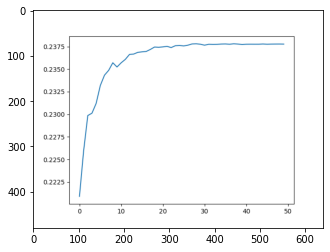

In [ ]:
from PIL import Image
img = Image.open('/content/drive/MyDrive/DVQA/SAN-DVQA/val_acc.png').convert('RGB')
plt.imshow(img)

#### Loading the weights obtained from training

In [ ]:
saved_state = torch.load('/content/drive/MyDrive/DVQA/SAN-DVQA/2022-06-23_13:00:45.pth', map_location=device)
tokens = len(saved_state['vocab']['question']) + 1
saved_state.keys()

dict_keys(['name', 'tracker', 'config', 'weights', 'eval', 'vocab'])

In [ ]:
# Loading the model with weights

import importlib.util

MODULE_PATH = "/content/pytorch-vqa/model.py"
MODULE_NAME = "model"

spec = importlib.util.spec_from_file_location(MODULE_NAME, MODULE_PATH)
model = importlib.util.module_from_spec(spec)
spec.loader.exec_module(model)

vqa_net = torch.nn.DataParallel(model.Net(tokens))
vqa_net.load_state_dict(saved_state['weights'])
vqa_net.to(device)
vqa_net.eval()

DataParallel(
  (module): Net(
    (text): TextProcessor(
      (embedding): Embedding(1126, 300, padding_idx=0)
      (drop): Dropout(p=0.5, inplace=False)
      (tanh): Tanh()
      (lstm): LSTM(300, 1024)
    )
    (attention): Attention(
      (v_conv): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (q_lin): Linear(in_features=1024, out_features=512, bias=True)
      (x_conv): Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))
      (drop): Dropout(p=0.5, inplace=False)
      (relu): ReLU(inplace=True)
    )
    (classifier): Classifier(
      (drop1): Dropout(p=0.5, inplace=False)
      (lin1): Linear(in_features=5120, out_features=1024, bias=True)
      (relu): ReLU()
      (drop2): Dropout(p=0.5, inplace=False)
      (lin2): Linear(in_features=1024, out_features=27, bias=True)
    )
  )
)

#### Looking at the vocab

In [ ]:
vocab = saved_state['vocab']
vocab.keys()  # dict_keys(['question', 'answer'])
list(vocab['question'].items())

[('the', 1),
 ('in', 2),
 ('of', 3),
 ('is', 4),
 ('how', 5),
 ('many', 6),
 ('what', 7),
 ('than', 8),
 ('value', 9),
 ('are', 10),
 ('chart', 11),
 ('bars', 12),
 ('bar', 13),
 ('accuracy', 14),
 ('people', 15),
 ('values', 16),
 ('a', 17),
 ('least', 18),
 ('object', 19),
 ('sold', 20),
 ('algorithm', 21),
 ('units', 22),
 ('preferred', 23),
 ('item', 24),
 ('whole', 25),
 ('percentage', 26),
 ('horizontal', 27),
 ('one', 28),
 ('at', 29),
 ('scale', 30),
 ('presented', 31),
 ('smaller', 32),
 ('contain', 33),
 ('dataset', 34),
 ('were', 35),
 ('prefer', 36),
 ('category', 37),
 ('each', 38),
 ('color', 39),
 ('larger', 40),
 ('more', 41),
 ('without', 42),
 ('solid', 43),
 ('single', 44),
 ('patterns', 45),
 ('with', 46),
 ('by', 47),
 ('have', 48),
 ('all', 49),
 ('most', 50),
 ('store', 51),
 ('smallest', 52),
 ('sum', 53),
 ('largest', 54),
 ('and', 55),
 ('less', 56),
 ('individual', 57),
 ('groups', 58),
 ('objects', 59),
 ('there', 60),
 ('algorithms', 61),
 ('does', 62),
 ('

## Testing the model
---

In [ ]:
import importlib.util

MODULE_PATH = "/content/pytorch-vqa/resnet/resnet.py"
MODULE_NAME = "resnet"

spec = importlib.util.spec_from_file_location(MODULE_NAME, MODULE_PATH)
resnet = importlib.util.module_from_spec(spec)
spec.loader.exec_module(resnet)

import torchvision.transforms as transforms
from PIL import Image

def get_transform(target_size, central_fraction=1.0):
    return transforms.Compose([
        transforms.Resize(int(target_size / central_fraction)),
        transforms.CenterCrop(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

class ResNetLayer4(torch.nn.Module):
    def __init__(self):
        super(ResNetLayer4, self).__init__()
        self.model = resnet.resnet152(pretrained=True)
        
        # from  visual_qa_analysis/config.py
        image_size = 384  # scale shorter end of image to this size and centre crop
        #output_size = image_size // 32  # size of the feature maps after processing through a network
        output_features = 2048  # number of feature maps thereof
        central_fraction = 0.875 # only take this much of the centre when scaling and centre cropping

        self.transform = get_transform(image_size, central_fraction)

        def save_output(module, input, output):
            self.buffer = output
        self.model.layer4.register_forward_hook(save_output)

    def forward(self, x):
        self.model(x)
        return self.buffer
    
    def image_to_features(self, img_file):
        img = Image.open(img_file).convert('RGB')
        img_transformed = self.transform(img)
        #print(img_transformed.size())
        img_batch = img_transformed.unsqueeze(0).to(device)
        return self.forward(img_batch) 
    
resnet_layer4 = ResNetLayer4().to(device)  # Downloads 241Mb model when first run

Downloading: "https://github.com/Cyanogenoid/pytorch-resnet/releases/download/hosting/resnet152-95e0e999.pth" to /root/.cache/torch/hub/checkpoints/resnet152-95e0e999.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [ ]:
# Sample images : 
image_path, image_files = '/content/data/images/test/bar_val_easy_0000000', []
os.makedirs('/content/data/images/test', exist_ok=True)
for i in range(1, 6): # Testing on 5 images as question-answer pair for test set is not available in VQA dataset
    image_file=image_path + str(i) + '.png'
    image_files.append(image_file)
image_files

['/content/data/images/test/bar_val_easy_00000001.png',
 '/content/data/images/test/bar_val_easy_00000002.png',
 '/content/data/images/test/bar_val_easy_00000003.png',
 '/content/data/images/test/bar_val_easy_00000004.png',
 '/content/data/images/test/bar_val_easy_00000005.png']

In [ ]:
v = []
for i in image_files:
  v.append(resnet_layer4.image_to_features(i))
len(v)

5

#### Testing the first image

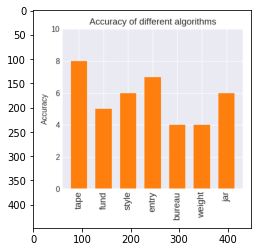

In [ ]:
image_idx = 4
image_filename = image_files[image_idx]

img = Image.open(image_filename).convert('RGB')
plt.imshow(img)

In [ ]:
v0 = v[1]

#### Encoding questions

In [ ]:
qtoken_to_index = vocab['question']
QUESTION_LENGTH_MAX = 30 # say...
    
def encode_question(question_str):
    """ Turn a question into a vector of indices and a question length """
    question_arr = question_str.lower().split(' ')
    #vec = torch.zeros(QUESTION_LENGTH_MAX).long()
    vec = torch.zeros(len(question_arr)).long()  
    for i, token in enumerate(question_arr):
        vec[i] = qtoken_to_index.get(token, 0)
    return vec.to(device), torch.tensor( len(question_arr) ).to(device)

In [ ]:
q, q_len = encode_question("is the bar chart horizontal")
q, q_len

(tensor([ 4,  1, 13, 11, 27], device='cuda:0'), tensor(5, device='cuda:0'))

In [ ]:
ans = vqa_net(v0, q.unsqueeze(0), q_len.unsqueeze(0))
ans.data.cpu()[0:10]

tensor([[   7.4409,    7.6171,    7.9276,    5.9839,    6.2612, -141.9188,
         -102.4825, -169.8291,  -94.3046, -178.5449, -108.1031,  -92.5269,
          -95.4282, -189.2240, -102.2505,  -96.6145, -186.9969,  -98.1860,
         -100.2277, -180.0064, -183.1726, -185.7260, -189.0553, -193.1476,
         -213.6298, -172.5548, -226.2117]])

In [ ]:
answer_words = ['UNDEF'] * len(vocab['answer'])
for w,idx in vocab['answer'].items():
    answer_words[idx]=w
len(answer_words), answer_words[:10] 

(27, ['e', 'o', 'n', 's', 'y', '0', '1', 'r', '9', 't'])

In [ ]:
_, answer_idx = ans.data.cpu().max(dim=1)
answer_words[ answer_idx ]

'n'

#### Trying various questions

In [ ]:
def vqa(image_filename, question_arr):
    plt.imshow(Image.open(image_filename).convert('RGB')); plt.show()    
    image_features = resnet_layer4.image_to_features(image_filename)
    for question_str in question_arr:
        _, answer_idx = vqa_single_softmax(image_features, question_str).max(dim=1)
        #print(question_str+" -> "+answer_words[ answer_idx ])
        print((answer_words[ answer_idx ]+' '*8)[:8]+" <- "+question_str)

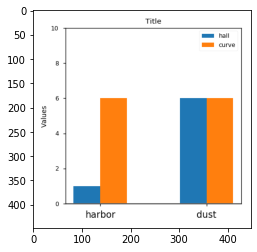

n        <- is there green in the picture
n        <- is there orange in the picture
o        <- is it not a bar plot


In [ ]:
image_idx = 1 

vqa(image_files[image_idx], [
    "is there green in the picture",
    "is there orange in the picture"
])